In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from collections import namedtuple, deque

import math
import random
import copy

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
class StyleNet(nn.Module):
    def __init__(self):
        super(StyleNet, self).__init__()
        vgg = torchvision.models.vgg11(pretrained=True)
        self.net = nn.Sequential()
        self.net.add_module("feature1", vgg.features[:3])
        self.net.add_module("feature2", vgg.features[3:6])
        self.net.add_module("feature3", vgg.features[6:11])
        self.net.add_module("feature4", vgg.features[11:16])
        self.net.add_module("feature5", vgg.features[16:])
        
    def forward(self, im):
        f1 = self.net.feature1(im)
        f2 = self.net.feature2(f1)
        f3 = self.net.feature3(f2)
        f4 = self.net.feature4(f3)
        f5 = self.net.feature5(f4)
        return f1, f2, f3, f4, f5

In [3]:
net = StyleNet().to(device)
# net = net.requires_grad_(False)

In [4]:
from PIL import Image
import cv2

In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

content_img = cv2.imread('./content.jpg')
content = cv2.resize(content_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)[:,:,::-1] / 255
content = (content - mean) / std
#https://lonelyplanet.co.kr/magazine/articles/articleLoad/AI_00002078?page=&keyType=

style_img = cv2.imread('./starry-night.jpg')
style = cv2.resize(style_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)[:,:,::-1] / 255
style = (style - mean) / std
#https://pixabay.com/illustrations/starry-night-vincent-van-gough-1093721/

style_target = net(torch.FloatTensor(style).permute(2,0,1).unsqueeze(0).to(device))

ss = []
for s in style_target:
    s = s.detach()
    channel = s.shape[1]
    s = s.squeeze().view(channel, -1).contiguous()
    s /= s.shape[1]
    ss.append(s.matmul(s.T))

style_target = ss
    
content_target = net(torch.FloatTensor(content).permute(2,0,1).unsqueeze(0).to(device))    
for c in content_target:
    c = c.detach()
c1,c2,c3,c4,c5 = content_target

In [9]:
img = torch.ones(content.shape).to(device)
img.uniform_()
# img = torch.FloatTensor(((img.squeeze().permute(1,2,0) - mean)/std).permute(2,0,1).unsqueeze(0)).to(device)
# img = torch.FloatTensor(torch.FloatTensor(content).permute(2,0,1).unsqueeze(0)).to(device)
img = torch.autograd.Variable(img, requires_grad=True)

EPOCH = 2000
LR = 0.01
alph = 1e-5
beta = 1e1
opt = optim.Adam([img], LR)

content_layer_index = 4

In [ ]:
for epoch in range(EPOCH):
    feature_map = net(torch.FloatTensor(img).permute(2,0,1).unsqueeze(0))

    style_loss = 0
    for i, (x, s) in enumerate(zip(feature_map,style_target)):
        channel = s.shape[1]
        x_ = x.squeeze().view(channel, -1).contiguous()
        x_ = x_/x_.shape[1]
        x_ = x_.matmul(x_.T)
        l = channel**2*((x_ - s) ** 2).sum()
        style_loss += l

    style_loss *= beta
    content_loss = alph * (1/2*(feature_map[content_layer_index] - content_target[content_layer_index])**2).sum()

    # loss = content_loss + style_loss
    loss = style_loss + content_loss 
    print(epoch, "%.10f %.10f"%(style_loss.cpu().item(), content_loss.cpu().item()))

    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    img = img.clamp(0,1)

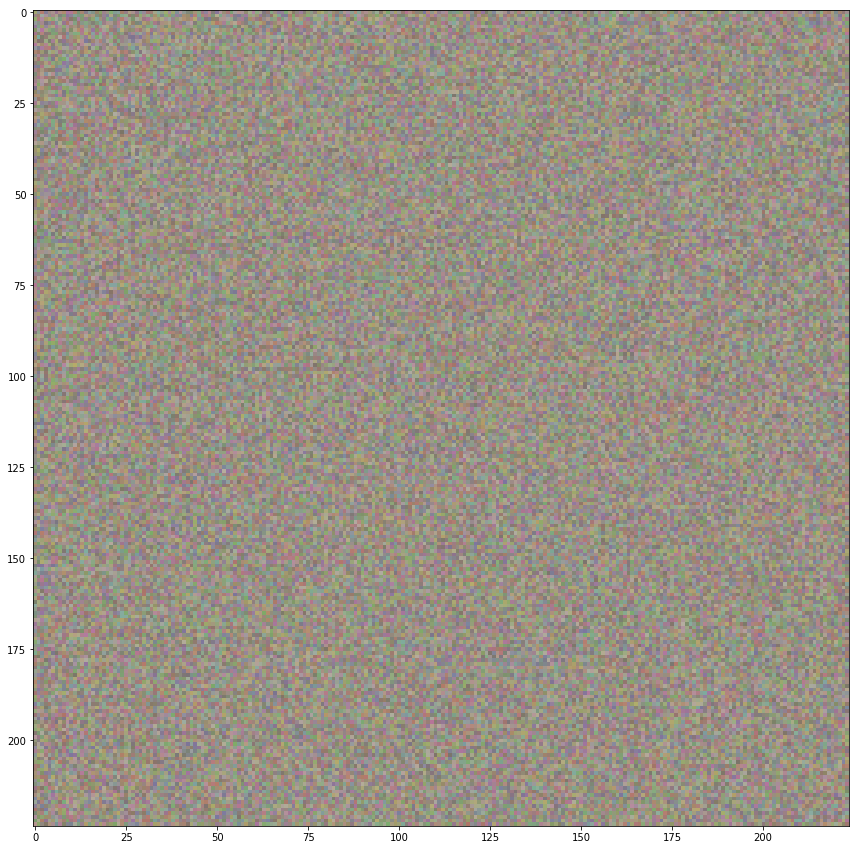

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(img.squeeze().permute(1,2,0).detach().cpu().numpy() * std + mean)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(img.squeeze().permute(1,2,0).detach().cpu().numpy() * std + mean)